In [1]:
##############################################################################
# Handle imports
##############################################################################
import traceback
from collections.abc import Iterable
import os
import pypdfium2 as pdfium
import re
import json
import jsonlines
import uuid
from openai import OpenAI
from langchain_openai import ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.schema import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from deepeval.models.base_model import DeepEvalBaseLLM
from deepeval import assert_test
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.metrics import GEval, AnswerRelevancyMetric, SummarizationMetric
from deepeval import evaluate
from huggingface_hub import snapshot_download, login, HfApi
from sklearn.model_selection import train_test_split
from transformers import AutoModelForCausalLM, AutoTokenizer
import xml.etree.ElementTree as etree
from datetime import datetime
import nltk
import pandas as pd
from datasets import load_dataset, interleave_datasets
nltk.download('punkt_tab')
from dotenv import load_dotenv
load_dotenv()
from transformers import DataCollatorForLanguageModeling, TrainingArguments
from trl import SFTConfig, SFTTrainer
from peft import LoraConfig
from transformers import EarlyStoppingCallback
from pydantic import BaseModel, Field
import torch
import optuna
import traceback
torch.cuda.empty_cache()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
##############################################################################
# Set up variables
##############################################################################
SOURCE_DIR="source_docs"
SOURCE_DIR_CHUNKED="source_docs_chunked"
MARKDOWN_DIR="markdown"
MARKDOWN_URI_PREFIX="https://raw.githubusercontent.com/agapebondservant/code-generation-capstone/refs/heads/main/eda/resources"
REPORT_DIR="reports"
OUTPUT_DIR="output"
INVALID_DIR="invalid"
ERROR_DIR="error" 
EVAL_DIR = "evals"
MODEL_DIR="models"
MODEL_IDS = ["ibm-granite/granite-4.0-h-tiny"]
DEVICE="cuda"
DATASET_REPO=f"{os.getenv('HF_USERNAME')}/codegen"

In [3]:
##############################################################################
# Set up object instances and generic utility func
##############################################################################

main_llm_client = OpenAI(
    
    api_key=os.getenv('OPENROUTER_TOKEN'),
    
    base_url=os.getenv('OPENROUTER_API_BASE'),
)

baseline_llm_client = OpenAI(
    
    api_key=os.getenv('HF_TOKEN'),
    
    base_url="https://718jwj9b54slpz-8000.proxy.runpod.net/v1",
)

candidate_llm_client = OpenAI(
    
    api_key=os.getenv('HF_TOKEN'),
    
    base_url = "https://q5hglygc7l2gbucf.us-east-1.aws.endpoints.huggingface.cloud",
)

def llm_tool(client, model, inputs, system_prompt, user_prompt):
    try:

        _system_prompt = system_prompt.replace("{inputs}", inputs)
        
        _user_prompt = user_prompt.replace("{inputs}", inputs)
        
        response = client.chat.completions.create(
            
            model=model,
            
            messages=[
                
                {"role": "system", "content": _system_prompt},
                
                {"role": "user", "content": _user_prompt}
            ],
            
            temperature=0.1,
        )
        
        answer = response.choices[0].message.content.strip()

        return answer
        
    except Exception as e:
        
        print(f"Error querying LLM:")

        traceback.print_exc() 
        
        return None

class DataGeneratorLLM(DeepEvalBaseLLM):
    def __init__(
        self,
        model
    ):
        self.model = model

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        chat_model = self.load_model()
        return chat_model.invoke(prompt).content

    async def a_generate(self, prompt: str) -> str:
        chat_model = self.load_model()
        res = await chat_model.ainvoke(prompt)
        return res.content

    def get_model_name(self):
        return "Custom Data Generator LLM (GPT-OSS)"

evaluator_llm = DataGeneratorLLM(
    ChatOpenAI(
        model=os.getenv("DATA_GENERATOR_MODEL_ID"),
        
        api_key=os.getenv('OPENROUTER_TOKEN'),
        
        base_url=os.getenv('OPENROUTER_API_BASE'),
        
        temperature=0.1,
    )
)

In [4]:
##############################################################################
# PROMPTS AND PROMPT TYPES
##############################################################################

github_system_prompt = """
You are a helpful assistant that identifies relevant files in a codebase.
"""

github_query_prompt = """
Given the following file paths in a repository:
{inputs}

Which of these files are the most relevant to a JSP web application?

List only the relevant file paths, one per line. Try to limit the number of files to 5.
"""

summary_system_prompt = """
You are a skilled software engineer with expertise in many programming languages and platforms.
"""

summary_prompt = """
Your task is to analyze this code and provide an explanation of the code.
    
Instructions:
1. Provide a concise explanation that summarizes the purpose of the code without getting into too many specific technical details.
2. If the provided snippet does not appear to be valid code, indicate that this is not valid code.
3. Also exclude any details that link the requirements to a specific programming language or framework.

Code:
{inputs}

Summary:
"""

sdd_system_prompt = """
"You are a Technical Writer. 
"""

sdd_prompt = """
"Here is some code, including a brief code summary:
{inputs}

Using the summary above, generate a language-agnostic Software Design Document (SDD). 
The document should be structured, professional, and suitable for both technical and non-technical stakeholders.
Also exclude any details that link the requirements to a specific programming language or framework.
Instead, it should focus on universal concepts and architecture rather than specific code, 
meaning it can be implemented in any programming language.

The SDD must include the following sections:

**1. System Architecture**
*   **Overall Design:** Describe the main architectural patterns used and how the different components interact. 
*   **Key Components:** Detail the primary modules, classes, domain model and/or services and their responsibilities.

**2. Functional Requirements**
*   **Input Handling:** How does the system accept inputs?
*   **Data Processing:** Detail the main logic, algorithms, and data transformations.
*   **Output Generation:** How are results produced and presented?

**3. Business Requirements**
*   **Business Rules:** Specific rules that govern how the business operates, which the software must enforce.
*   **Success Criteria:** Measurable criteria to determine if the project is successful, also known as acceptance criteria.

Only use the context provided in the summary above. Do not stray from the context provided in the summary. 
Include named components and objects based on the context where it makes sense.
"""

In [5]:
##############################################################################
# GIT REPOS
##############################################################################

git_repos = [
    ("https://github.com/dmorrison/jsp-guestbook", "master"),
    ("https://github.com/saif95bd/webApp_servlet", "master"),
    ("https://github.com/Stas88/WebApp_with_Servlets_and_JSPs", "master"),
    ("https://github.com/usausa/Smart-Java-WebLayout", "master"),
    ("https://github.com/dmisiuk/myapp-headfirst", "master"),
]

### Evaluate the candidate models
Evaluate the candidate models using the following metrics / bechmarks:
- BLEU-4
- ROUGE
- METEOR
- BERTScore
- CodeBLEU (only supported for the target languages - React, NodeJS)
- LLM-as-Judge for Pairwise Evaluation (G-Eval)
- Human-In-The-Loop (HITL)

In [6]:
##############################################################################
# Evaluation Methods
##############################################################################

from evaluate import load
from deepeval.metrics import ArenaGEval
from deepeval.test_case import ArenaTestCase
from deepeval import compare

nltk.download('wordnet')
nltk.download('punkt')
bleu_metric = load("bleu")
rouge_metric = load("rouge")
meteor_metric = load("meteor")
bertscore_metric = load("bertscore")
codebleu_metric = load("dvitel/codebleu")

[os.makedirs(dirname, exist_ok=True) for dirname in [
    EVAL_DIR, f"{EVAL_DIR}/images"
]]

def compute_bleu4_scores(predictions, references):
    """
    Computes BLEU-4 Scores
    """
    # predictions = ["this is a test", "another example sentence"]
    # references = [["this is a test"], ["a different example"]]
    results = bleu_metric.compute(predictions=predictions, references=references)
    return results["bleu"]

def compute_rouge_scores(predictions, references):
    """
    Computes ROUGE Scores
    """
    # predictions = ["Your summary 1", "Your summary 2"]
    # references = [["Reference summary 1", "Reference summary 2"]]
    results = rouge_metric.compute(predictions=predictions, references=references)
    return results["rougeL"]

def compute_meteor_scores(predictions, references):
    """
    Computes METEOR Scores
    """
    # predictions = ["this is a test", "another example sentence"]
    # references = [["this is a test"], ["a different example"]]
    results = meteor_metric.compute(predictions=predictions, references=references)
    return results["meteor"]
    

def compute_bert_scores(predictions, references):
    """
    Computes BERT Scores
    """
    # predictions = ["this is a test", "another example sentence"]
    # references = [["this is a test"], ["a different example"]]
    results = bertscore_metric.compute(predictions=predictions, references=references, lang="en")
    return results["f1"]

def compute_codebleu_scores(predictions, references):
    """
    Computes CodeBLEU Scores
    """
    # predictions = ["this is a test", "another example sentence"]
    # references = [["this is a test"], ["a different example"]]
    results = codebleu_metric.compute(predictions=predictions, references=references)
    return results

def compute_summarization_eval_scores(_input, prediction):
    """
    Computes Summarization test scores, which combine alignment and coverage scores.
    """
    try:
        results = []
                                     
        test_case = LLMTestCase(input=_input, actual_output=prediction)
        
        metric = SummarizationMetric(
            
            threshold=0.5,
                
            model=evaluator_llm
        )
    
        metric.measure(test_case)
        
        return metric.score
        
    except Exception as e:
        return -1

def compute_arena_geval_scores(_input, baseline, candidate):
    """
    Computes ArenaGEval Scores
    """
    try:
        a_test_case = ArenaTestCase(
            contestants={
                "granite-4.0-h-tiny_l": LLMTestCase(
                    input=_input,
                    actual_output=candidate,
                ),
                "granite-4.0-h-tiny": LLMTestCase(
                    input=_input,
                    actual_output=baseline,
                ),
            },
        )
        
        metric = ArenaGEval(
            name="Friendly",
            
            criteria="Choose the winner of the more helpful contestant based on the input and actual output",
            
            evaluation_params=[
                LLMTestCaseParams.INPUT,
                LLMTestCaseParams.ACTUAL_OUTPUT,
            ],
            
            model=evaluator_llm
        )
        
        metric.measure(a_test_case)
        
        return metric.score
        
    except Exception as e:
        
        return -1

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Downloaded keywords to /workspace/.cache/huggingface/metrics/codebleu/default/downloads/extracted/6b92998aabc08bb8082142554698b8b9b3878803d19c8a38029506ca40f0e6a8
Downloaded languages.so to /workspace/.cache/huggingface/hub/spaces--dvitel--codebleu/snapshots/f8862f74b23bb1d0c383f31c32db54269b5ba104/my-languages.so


### Set up Model Evaluation Task
In order to setup the model evaluation task, we must generate the following features:
- **Inputs**: This represents the inputs that will be used for the evaluations.
- **References**: This represents the ground truth or reference data that will be used for **pointwise evaluations** such as BLEU-4, ROUGE-N, Meteor and BERTScore.
- **Baselines**: This represents the outputs generated by the baseline model (pre-finetuning).
- **Candidates**: This is an output dataset which represents the outputs generated by the candidate model (the selected finetuned model).
- **Prompt templates**: This is a separate input dataset which includes the prompts used for generating the outputs. Prompt quality has a direct impact on model performance. However, the prompt templates will not be evaluated in this project due to limited scope.

In [7]:
##############################################################################
# Github Tool Methods
##############################################################################
import os
from ghapi.core import GhApi
import os
from urllib.parse import urlparse
import base64

def get_git_repo_api(git_repo):
    """Given a git repo, returns the GhApi connector object."""

    repo_owner, repo_name = urlparse(git_repo).path.split("/")[1], urlparse(git_repo).path.split("/")[2]
    
    print(f"Creating repo object for {repo_owner}/{repo_name}...")

    repo_api = GhApi(owner=repo_owner, repo=repo_name, token=os.environ.get("GH_TOKEN"))

    return repo_api

def get_repo_structure(tree_sha, repo_api):
    """Fetches the file structure of a GitHub repository."""
    files = []
    
    tree = repo_api.git.get_tree(tree_sha=tree_sha, recursive=1)
    
    for file_obj in tree['tree']:
        
        files.append(file_obj['path'])
        
    return files

def get_github_file_content(file_path, repo_api):
    
    content = repo_api.repos.get_content(path=file_path).content
    
    content = base64.b64decode(content).decode('utf-8')

    return content

def get_relevant_files(tree_sha, repo_api):
    
    repo_files = get_repo_structure(tree_sha, repo_api)
    
    print(f"Found {len(repo_files)} total files.")

    return repo_files


def get_relevant_file_content(repo_files, repo_api):

    output = None
    
    if repo_files:
        
        relevant_files = llm_tool(main_llm_client,

                                  os.getenv("DATA_GENERATOR_MODEL_ID"),
                                  
                                  '- '.join(repo_files), 
                                  
                                  github_system_prompt, 
                                  
                                  github_query_prompt)
    
        if relevant_files:

            output = [f"""============={f}
                      {get_github_file_content(f.strip(), repo_api)}"""
                      for f in relevant_files.split('\n') if f]

            output = "\n".join(output)

    return output

def get_sdd(code, client, model):

    summary, sdd = None, None

    if code:

        summary = llm_tool(client,

                           model,
                                      
                           code,
                          
                           summary_system_prompt, 
                          
                           summary_prompt)
    
        input = f"Code:\n {code}\n\nSummary:\n {summary}"

        sdd = llm_tool(client,

                       model,
                       
                       input,
                       
                       sdd_system_prompt, 
                       
                       sdd_prompt)
    
    return sdd
    

In [8]:
##############################################################################
# PIPELINES
##############################################################################

def generate_evaluation_dataset():
    """
    Generates evaluation data.
    """
    evaluation_data = []
    
    for git_repo, tree_sha in git_repos:
    
        repo_api = get_git_repo_api(git_repo)
    
        files = get_relevant_files(tree_sha, repo_api)
    
        code = get_relevant_file_content(files, repo_api)

        reference = get_sdd(code, main_llm_client, os.getenv("DATA_GENERATOR_MODEL_ID"))
    
        baseline = get_sdd(code, baseline_llm_client, "ibm-granite/granite-4.0-h-tiny")

        candidate = get_sdd(code, baseline_llm_client, "ibm-granite/granite-4.0-h-tiny")
    
        evaluation_data.append(dict(
            input=code,
            
            reference=reference,
            
            baseline=baseline,
            
            candidate=candidate
        ))

    return pd.DataFrame(evaluation_data)

def evaluations_pipeline(eval_df=None):
    """
    Runs evaluation pipeline.
    """
    try:
        ##############################################################################
        # Generate input data
        ##############################################################################
        if not len(eval_df):
            
            eval_df = generate_evaluation_dataset()
    
        ##############################################################################
        # Run evaluations for input data
        ##############################################################################
        
        print("Computing evaluations...")
        
        for target in ['baseline', 'candidate']:
            eval_df[target+'_bleu4'] = eval_df.apply(lambda row: compute_bleu4_scores([row[target]], 
                                                                                [row['reference']]), axis=1)
                
            eval_df[target+'_rouge'] = eval_df.apply(lambda row: compute_rouge_scores([row[target]], 
                                                                                [row['reference']]), axis=1)
                
            eval_df[target+'_meteor'] = eval_df.apply(lambda row: compute_meteor_scores([row[target]], 
                                                                                [row['reference']]), axis=1)
                
            eval_df[target+'_bert'] = eval_df.apply(lambda row: compute_bert_scores([row[target]], 
                                                                                [row['reference']]), axis=1)
            
                
            eval_df[target+'_summarization'] = eval_df.apply(lambda row: compute_summarization_eval_scores(row["input"], 
                                                                                row[target]), axis=1)   
                
        eval_df[target+'_arena'] = eval_df.apply(lambda row: compute_arena_geval_scores(row["input"],
                                                                            row["baseline"],
                                                                            row["candidate"]), axis=1)  
    
        ##############################################################################
        # Push to HuggingFace
        ##############################################################################
        print("Pushing to HuggingFace...")
        
        eval_df.to_json(f"{EVAL_DIR}/evaluation_data.jsonl", orient='records', lines=True)
    
        eval_dataset = load_dataset('json', data_files=f"{EVAL_DIR}/evaluation_data.jsonl")
    
        eval_dataset.push_to_hub("codegen-evaluation-data")

    except Exception as e:

        print(f"Error generating evaluation dataset: {e}")
        
        traceback.print_exc() 
        

### Model Evaluations
Run the evaluations pipeline!

In [9]:
eval_df = generate_evaluation_dataset() #pd.read_json(f"{EVAL_DIR}/evaluation_data.jsonl", lines=True) #

Creating repo object for dmorrison/jsp-guestbook...
Found 46 total files.
Creating repo object for saif95bd/webApp_servlet...
Found 139 total files.
Creating repo object for Stas88/WebApp_with_Servlets_and_JSPs...
Found 79 total files.
Creating repo object for usausa/Smart-Java-WebLayout...
Found 32 total files.
Creating repo object for dmisiuk/myapp-headfirst...
Found 28 total files.


In [10]:
evaluations_pipeline(eval_df)

Computing evaluations...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Pushing to HuggingFace...


Generating train split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/883 [00:00<?, ?B/s]

### Model Visualizations
Generate visualizations from the metrics.

In [11]:
##############################################################################
# Preprocess data for visualization
##############################################################################
visualization_df = pd.read_json(f"{EVAL_DIR}/evaluation_data.jsonl", lines=True)
candidate_bert, baseline_bert = visualization_df["candidate_bert"].to_list(), visualization_df["baseline_bert"].to_list()
visualization_df["candidate_bert"] = [x[0] for x in candidate_bert]
visualization_df["baseline_bert"] = [x[0] for x in baseline_bert]
visualization_df.replace({-1: 0}, inplace=True)

baseline_columns = visualization_df.filter(regex=r"baseline.+", axis=1).columns
candidate_columns = visualization_df.filter(regex=r"candidate.+", axis=1).columns

plot_dfs = []

for b_col, c_col in zip(baseline_columns, candidate_columns):
    plot_dfs.append(pd.DataFrame({b_col: visualization_df[b_col], 
                                 c_col: visualization_df[c_col]},
                                index=visualization_df.index.to_list()))   

plot_dfs[0]

,baseline_bleu4,candidate_bleu4
0,0.046459,0.049695
1,0.029770,0.064787
2,0.031056,0.050696
3,0.047878,0.049149
4,0.063194,0.042487


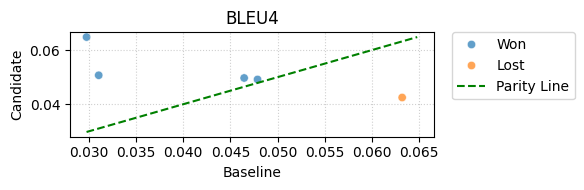

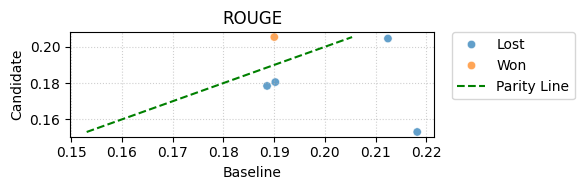

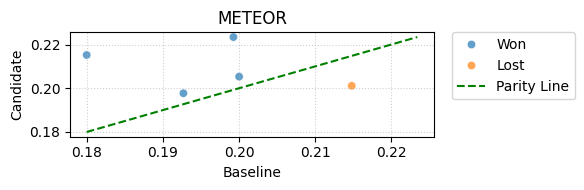

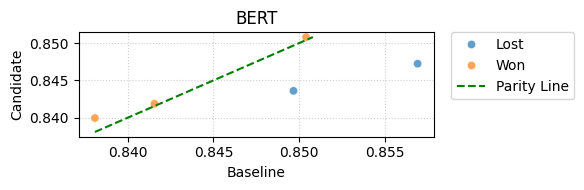

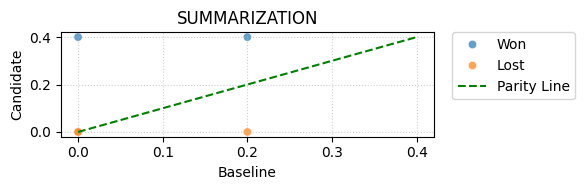

In [12]:
##############################################################################
# Plot parity plot
##############################################################################
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

_dfs = []

for i, plot_df in enumerate(plot_dfs):
    metric_name = plot_df.columns[0].partition("_")[2].capitalize()
    _df = plot_df.rename(columns={col: col.partition("_")[0].capitalize() for col in plot_df.columns})
    _df["won"] = "Lost"
    _df["metric_type"] = metric_name
    _df.loc[_df["Candidate"] > _df["Baseline"], 'won'] = "Won"
    _dfs.append(_df)
    
    plt.figure(figsize=(6, 2))
    sns.scatterplot(x='Baseline', y='Candidate', data=_df, alpha=0.7, hue="won")
    
    
    min_val = min(_df['Baseline'].min(), _df['Candidate'].min())
    max_val = max(_df['Candidate'].max(), _df['Candidate'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='green', linestyle='--', label='Parity Line')
    
    plt.xlabel('Baseline')
    plt.ylabel('Candidate')
    plt.title(metric_name.upper())
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.tight_layout()
    
    plt.savefig(f"{EVAL_DIR}/images/parity_plots{i}.png")
    plt.show()

In [13]:
total_samples = 5
combined_plot_df = pd.concat(_dfs)
combined_plot_df = combined_plot_df.drop(columns=["Baseline","Candidate"])
combined_plot_df = combined_plot_df.groupby(['won', 'metric_type']).size().reset_index(name='Number of Wins')
combined_plot_df

,won,metric_type,Number of Wins
0,Lost,Bert,2
1,Lost,Bleu4,1
2,Lost,Meteor,1
3,Lost,Rouge,4
4,Lost,Summarization,3
5,Won,Bert,3
6,Won,Bleu4,4
7,Won,Meteor,4
8,Won,Rouge,1
9,Won,Summarization,2


In [14]:
import dataframe_image as dfi
win_rate_df = combined_plot_df[combined_plot_df["won"]=="Won"]
win_rate_df['Win Rate'] = combined_plot_df["Number of Wins"]/total_samples
win_rate_df = win_rate_df.drop(columns=["won","Number of Wins"])
win_rate_df
# dfi.export(win_rate_df, f"{EVAL_DIR}/images/win_rates.png")

/tmp/ipykernel_16447/4033644378.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  win_rate_df['Win Rate'] = combined_plot_df["Number of Wins"]/total_samples


,metric_type,Win Rate
5,Bert,0.6
6,Bleu4,0.8
7,Meteor,0.8
8,Rouge,0.2
9,Summarization,0.4


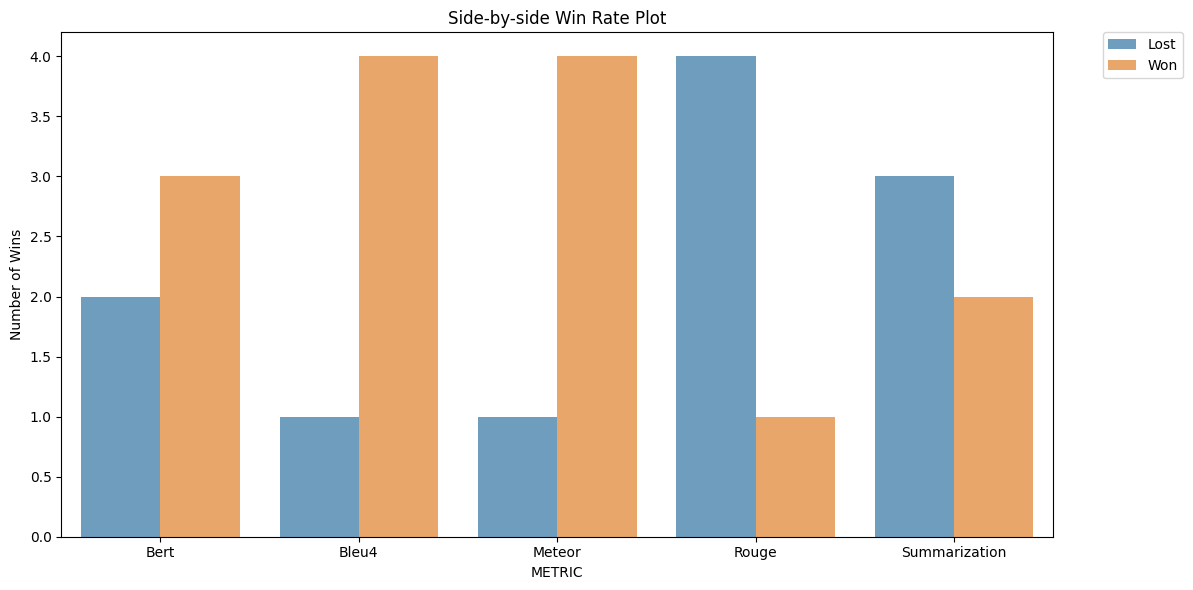

In [15]:
##############################################################################
# Plot side-by-side bar plot
##############################################################################

plt.figure(figsize=(12, 6))
sns.barplot(x='metric_type', y="Number of Wins", hue="won", data=combined_plot_df, alpha=0.7, errorbar=None)

plt.xlabel('METRIC')
plt.ylabel('Number of Wins')
plt.title("Side-by-side Win Rate Plot")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig(f"{EVAL_DIR}/images/metric_barplot.png")
plt.show()

### Observations:
- A comprehensive sample size should include at least 50 samples in order to perform statistical significance testing. This would require conducting multiple trials with the selected code repositories. Each trial would comprise of 5 separate github inputs; hence, to accomplish this, 10 trials would be required. However, for the current phase only a small sample size (1 trial with 5 samples) was generated due to time constraints. 
- Due to the small sample size (5 samples), there is not enough data to perform a statistical significance test which would analyze whether the observed win rates are statistically significant.
- Instead, descriptive statistical analysis shows a general improvement over the baseline for BERTScore, BLEU4 and METEOR, which are more generation-focused scores. Conversely, it shows a general decline in ROUGE-L and Summarization, which are more focused on summarization. 
- The results above show the need for more experimentation in order to improve the baseline performance.